In [84]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import matplotlib.pyplot as plt
from training.util import plot_losses, GaussWrapper, sgd, adam
from training.regresssion import RegressionResults, plot_calibration, plot_table
from training import toy
from experiments.toy_regression import gap_datasets, plot_grid, store_results, NOISE, wrap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
device = torch.device("cpu")

In [83]:
learn_var = False

In [85]:
from training.pp import PointPredictor
from training.swag import SwagModel
from training.ensemble import Ensemble
from training.bbb import GaussianPrior, BBBModel
from training.gp import GaussianProcess

def train_models(dataset, batch_size):
    torch.manual_seed(42)
    trainloader = torch.utils.data.DataLoader(dataset.trainset, batch_size=batch_size)


    torch.manual_seed(42)
    gp = GaussianProcess(dataset.normalized_xs, dataset.normalized_ys, NOISE / dataset.y_std**2)
    gp.train_model(100, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    pp = wrap(PointPredictor(layers))
    pp.train_model(100, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    swag_config = {
        "start_epoch": 70,
        "update_every_batches": len(trainloader),
        "deviation_samples": 30
    }
    swag = wrap(SwagModel(layers, swag_config))
    swag.train_model(100, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    diag_swag_config = {
        "start_epoch": 70,
        "update_every_batches": len(trainloader),
        "deviation_samples": 30,
        "use_low_rank_cov": False
    }
    diag_swag = wrap(SwagModel(layers, diag_swag_config))
    diag_swag.train_model(100, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    ensemble = Ensemble([wrap(PointPredictor(layers)) for _ in range(10)])
    ensemble.train_model(100, sgd(0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    mc_dropout = wrap(PointPredictor(layers))
    mc_dropout.train_model(200, sgd(0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    bbb_prior = GaussianPrior(0, 1)
    layers = [
        ("v_fc", (1, 32, bbb_prior)),
        ("relu", ()),
        ("v_fc", (32, 32, bbb_prior)),
        ("relu", ()),
        ("v_fc", (32, 1, bbb_prior))
    ]
    bbb = wrap(BBBModel(layers))
    bbb.train_model(200, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5,  mc_samples=2)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("v_fc", (32, 1, bbb_prior))
    ]
    bbb_ll = wrap(BBBModel(layers))
    bbb_ll.train_model(200, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5, mc_samples=2)

    torch.manual_seed(42)
    layers = [
        ("vlr_fc", (1, 32, 2, 1)),
        ("relu", ()),
        ("vlr_fc", (32, 32, 2, 1)),
        ("relu", ()),
        ("vlr_fc", (32, 1, 2, 1))
    ]
    bbb_lr2 = wrap(BBBModel(layers))
    bbb_lr2.train_model(200, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5, mc_samples=2)

    torch.manual_seed(42)
    layers = [
        ("vlr_fc", (1, 32, 5, 1)),
        ("relu", ()),
        ("vlr_fc", (32, 32, 5, 1)),
        ("relu", ()),
        ("vlr_fc", (32, 1, 5, 1))
    ]
    bbb_lr5 = wrap(BBBModel(layers))
    bbb_lr5.train_model(200, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5, mc_samples=2)


    return [gp, pp, ensemble, swag, diag_swag, mc_dropout, bbb, bbb_ll, bbb_lr2, bbb_lr5]

Epoch 0: loss 1.2292159795761108
Epoch 10: loss 1.1355578899383545
Epoch 20: loss 1.0447697639465332
Epoch 30: loss 0.9571568965911865
Epoch 40: loss 0.7480012774467468
Epoch 50: loss 0.5132562518119812
Epoch 60: loss 0.25471875071525574
Epoch 70: loss 0.16782860457897186
Epoch 80: loss 0.10412157326936722
Epoch 90: loss 0.08330896496772766
Epoch 100: loss 0.0661722868680954
Epoch 110: loss 0.06535176932811737
Epoch 120: loss 0.041139498353004456
Epoch 130: loss 0.05009382218122482
Epoch 140: loss 0.04720187187194824
Epoch 150: loss 0.036168333142995834
Epoch 160: loss 0.04821474850177765
Epoch 170: loss 0.040718693286180496
Epoch 180: loss 0.025697089731693268
Epoch 190: loss 0.024711141362786293
Final loss 0.022311275824904442
Test LML (BBB): 0.33516791462898254


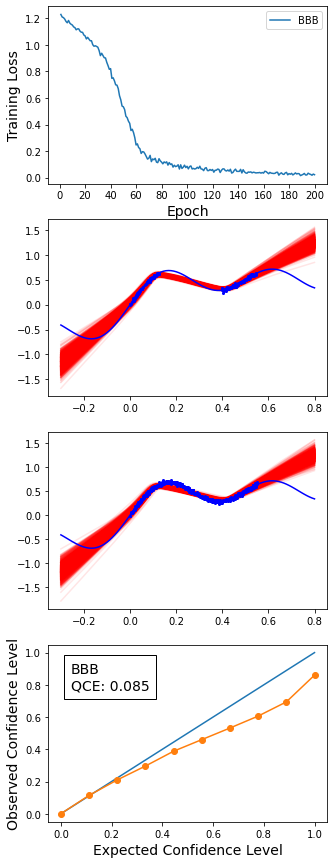

In [86]:
torch.manual_seed(42)

dataset, trainloader, testset = gap_datasets(device)

bbb_prior = GaussianPrior(0, 1)
layers = [
    ("v_fc", (1, 32, bbb_prior)),
    ("relu", ()),
    ("v_fc", (32, 32, bbb_prior)),
    ("relu", ()),
    ("v_fc", (32, 1, bbb_prior))
]
bbb = wrap(BBBModel(layers))
kl_grads, data_grads = bbb.train_model(200, adam(0.001), "mean", trainloader, 20, device, report_every_epochs=10, kl_rescaling=1, mc_samples=2)

fig, results = plot_grid(dataset, testset, [("BBB", bbb, 1000)], device)

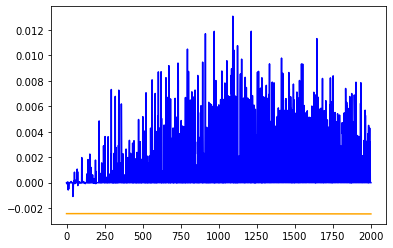

In [20]:
data_mad = (data_grads - data_grads.median(dim=1)[0].unsqueeze(-1)).abs().median(dim=1)[0]
#plt.plot(data_mad, color="blue")
plt.plot(data_grads.median(dim=1)[0], color="blue")
plt.plot(kl_grads.median(dim=1)[0], color="orange")
#plt.plot(data_grads[2])

torch.Size([1153])
tensor(0.0169, grad_fn=<MinBackward1>)
tensor(0.2178, grad_fn=<MeanBackward0>)
tensor(0.2968, grad_fn=<MaxBackward1>)


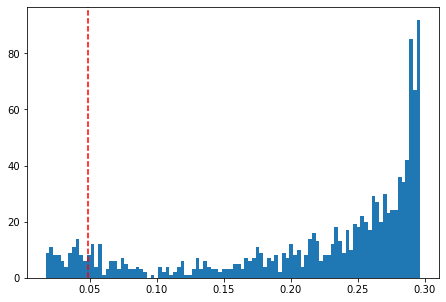

In [58]:
result = torch.tensor([])
for module in bbb.mean.model:
    if (hasattr(module, "sigmas")):
        result = torch.cat([result, module.sigmas()])

plt.hist(result.detach().numpy(), bins=100)[1]
plt.axvline(torch.nn.functional.softplus(torch.tensor(-3.0)), color="red", linestyle="--")
plt.tight_layout(pad=0)
#plt.savefig("results/vi/sigma_hist_1.pdf")
print(result.shape)
print(result.min())
print(result.mean())
print(result.max())

Epoch 0: loss 1.1672435998916626
Epoch 10: loss 1.0641183853149414
Epoch 20: loss 0.9946984648704529
Epoch 30: loss 0.9047680497169495
Epoch 40: loss 0.7585146427154541
Epoch 50: loss 0.5555235147476196
Epoch 60: loss 0.306156724691391
Epoch 70: loss 0.19250957667827606
Epoch 80: loss 0.07891196012496948
Epoch 90: loss 0.0348452627658844
Epoch 100: loss 0.01920551247894764
Epoch 110: loss 0.03561533987522125
Epoch 120: loss -0.0003266473941039294
Epoch 130: loss 0.006848287768661976
Epoch 140: loss 0.001288928440771997
Epoch 150: loss -0.007379381451755762
Epoch 160: loss -0.0010044628288596869
Epoch 170: loss -0.019752709195017815
Epoch 180: loss -0.018228305503726006
Epoch 190: loss -0.012630212120711803
Epoch 200: loss -0.014433721080422401
Epoch 210: loss -0.02765605039894581
Epoch 220: loss -0.021983833983540535
Epoch 230: loss -0.035851068794727325
Epoch 240: loss -0.03596215695142746
Final loss -0.02029411308467388
Test LML (BBB-LR): 0.5159111618995667


(<Figure size 360x1080 with 4 Axes>,
 [<training.regresssion.RegressionResults at 0x1d3c693d700>])

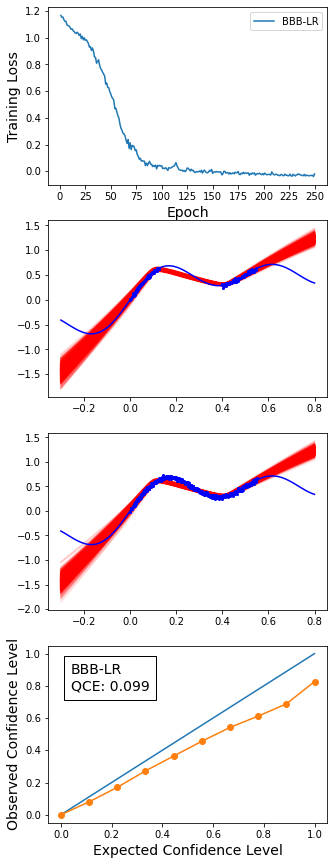

In [59]:
torch.manual_seed(42)

dataset, trainloader, testset = gap_datasets(device)

layers = [
    ("vlr_fc", (1, 32, 10, 1)),
    ("relu", ()),
    ("vlr_fc", (32, 32, 10, 1)),
    ("relu", ()),
    ("vlr_fc", (32, 1, 10, 1))
]
bbb_lr2 = wrap(BBBModel(layers))
bbb_lr2.train_model(250, adam(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=10, kl_rescaling=0.5, mc_samples=2)
plot_grid(dataset, testset, -0.3, 0.8, [("BBB-LR", bbb_lr2, 1000)], device)

In [67]:
results = [[] for _ in range(20)]

for seed in range(5):
    print(f"===== {seed}")
    dataset, dataloader, testset = gap_datasets(device)
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

    models = []
    eval_configs = []
    for K in range(1,21):
        print(f"== {K}")
        torch.manual_seed(seed)

        layers = [
            ("vlr_fc", (1, 32, K, 1)),
            ("relu", ()),
            ("vlr_fc", (32, 32, K, 1)),
            ("relu", ()),
            ("vlr_fc", (32, 1, K, 1))
        ]
        bbb_lrK = wrap(BBBModel(layers))
        bbb_lrK.train_model(250, adam(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=0, kl_rescaling=0.5, mc_samples=2)
        models.append(bbb_lrK)
        eval_configs.append((f"BBB LR-{K}", bbb_lrK, 1000))

    for i, (name, model, samples) in enumerate(eval_configs):
        results[i].append(RegressionResults(testloader, name, model.infer, samples, device, fit_gaussian=False, target_mean=dataset.y_mean, target_std = dataset.y_std))

===== 0
== 1
Final loss -0.03540802374482155
== 2
Final loss -0.025591708719730377
== 3
Final loss -0.026963744312524796
== 4
Final loss -0.032297149300575256
== 5
Final loss -0.0337551087141037
== 6
Final loss -0.028580034151673317
== 7
Final loss -0.03479568660259247
== 8
Final loss -0.026795854791998863
== 9
Final loss -0.02691083587706089
== 10
Final loss -0.03238692134618759
== 11
Final loss -0.04164482280611992
== 12
Final loss -0.017137186601758003
== 13
Final loss -0.036187171936035156
== 14
Final loss -0.03298236429691315
== 15
Final loss -0.03179185837507248
== 16
Final loss -0.02600836753845215
== 17
Final loss -0.029390383511781693
== 18
Final loss -0.025220952928066254
== 19
Final loss -0.028499307110905647
== 20
Final loss -0.0415412038564682
===== 1
== 1
Final loss -0.03944389522075653
== 2
Final loss -0.031348031014204025
== 3
Final loss -0.045591071248054504
== 4
Final loss -0.03923151269555092
== 5
Final loss -0.03952300548553467
== 6
Final loss -0.0340704470872879
==

| Gap Toy Regression   | Avg LML     | Mean MSE      | MSE of Means   | QCE         |
|----------------------+-------------+---------------+----------------+-------------|
| BBB LR-1             | 0.89 ± 0.24 | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.08 ± 0.01 |
| BBB LR-2             | 0.80 ± 0.21 | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.10 ± 0.01 |
| BBB LR-3             | 0.86 ± 0.17 | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.09 ± 0.01 |
| BBB LR-4             | 0.96 ± 0.11 | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.09 ± 0.01 |
| BBB LR-5             | 0.76 ± 0.18 | 0.004 ± 0.000 | 0.003 ± 0.000  | 0.09 ± 0.01 |
| BBB LR-6             | 0.83 ± 0.17 | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.09 ± 0.01 |
| BBB LR-7             | 0.88 ± 0.15 | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.09 ± 0.00 |
| BBB LR-8             | 0.85 ± 0.14 | 0.004 ± 0.000 | 0.003 ± 0.000  | 0.09 ± 0.01 |
| BBB LR-9             | 0.86 ± 0.15 | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.10 ± 0.01 |
| BBB LR-10            | 0.75 ± 0.18 | 0.003 ± 0.000 |

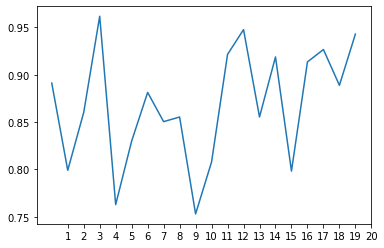

In [75]:
plot_table("Gap Toy Regression", results, "results/toy/regression_gap_lr.txt")

Test LML (BBB LR-1): 0.8295542001724243
Test LML (BBB LR-2): 0.6116978526115417
Test LML (BBB LR-3): 0.8192546963691711
Test LML (BBB LR-4): 0.8078017830848694
Test LML (BBB LR-5): 0.6128537058830261
Test LML (BBB LR-6): 0.8156030774116516
Test LML (BBB LR-7): 1.145634651184082
Test LML (BBB LR-8): 0.805411696434021
Test LML (BBB LR-9): 0.9608200788497925
Test LML (BBB LR-10): 0.9975020885467529
Test LML (BBB LR-11): 0.8234630823135376
Test LML (BBB LR-12): 1.1964620351791382
Test LML (BBB LR-13): 0.8556326031684875
Test LML (BBB LR-14): 0.8968547582626343
Test LML (BBB LR-15): 0.6951597332954407
Test LML (BBB LR-16): 0.6906633973121643
Test LML (BBB LR-17): 0.8977761268615723
Test LML (BBB LR-18): 0.8443577885627747
Test LML (BBB LR-19): 0.7314607501029968
Test LML (BBB LR-20): 0.987156867980957


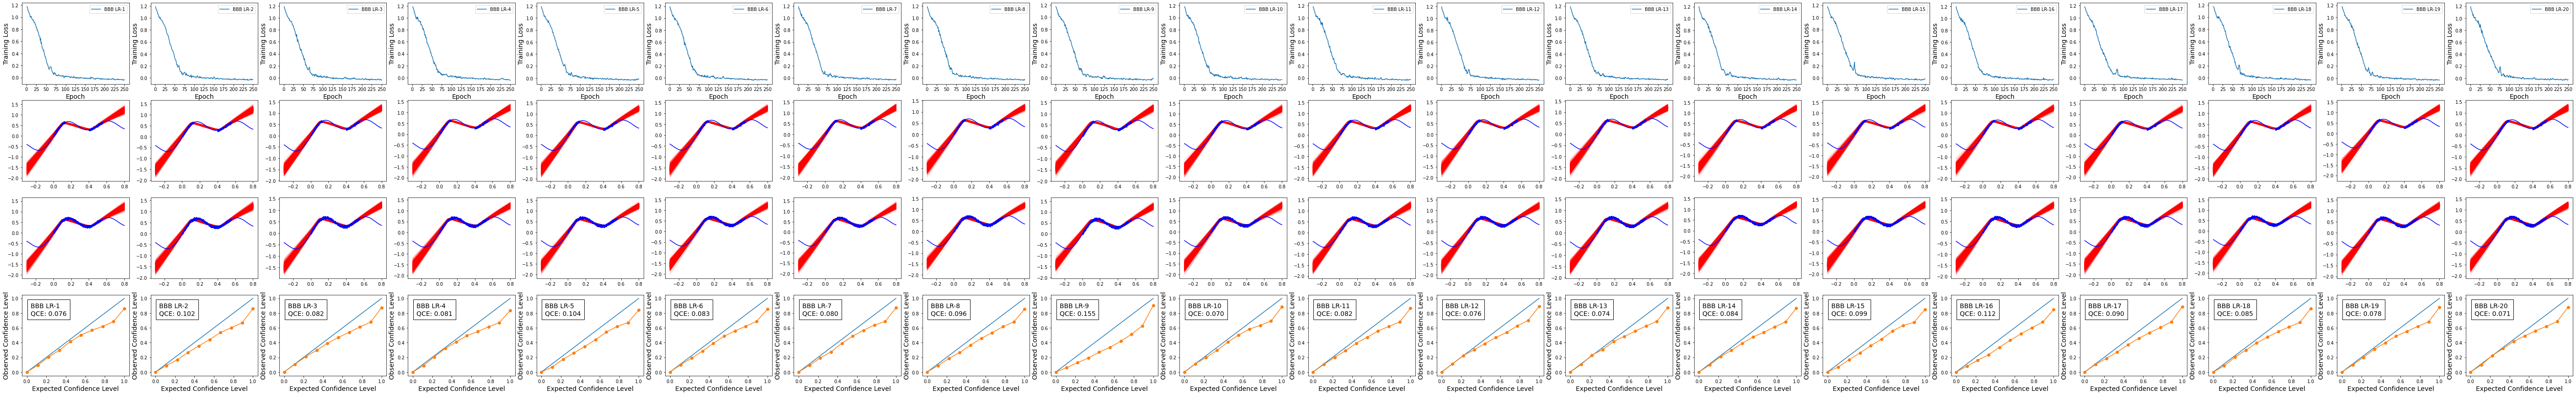

In [78]:
plot_grid(dataset, testset, -0.3, 0.8, eval_configs, device)[0].savefig("results/toy/regression_gap_lr.pdf")

In [ ]:
torch.manual_seed(42)
dataset = toy.TrigonometricToyDataset([(0, 0.5, 200)], noise)
dataset.plot_dataset(-0.2, 0.7, plt.subplot())

models = train_models(dataset, 20)

fig, results = plot_grid(dataset, dataset.generate_testset(0.0, 0.5, 200, noise), -0.1, 0.6, [
    ("Gaussian Process", models[0], 1000),
    ("MAP", models[1], 1000),
    ("Ensemble-5", models[2], 1000),
    ("SWAG", models[3], 1000),
    ("SWAG-Diagonal", models[4], 1000),
    ("MC Dropout", models[5], 1000),
    ("Bayes By Backprop", models[6], 1000),
    ("Bayes By Backprop (LL)", models[7], 1000)
], device)

#fig.savefig("results/toy/regression_simple.png")

#plot_table("Simple Toy Regression", [[result] for result in results], "results/toy/regression_simple.txt")

Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


| Gap Toy Regression       | Avg LML      | Mean MSE      | MSE of Means   | QCE         |
|--------------------------+--------------+---------------+----------------+-------------|
| Gaussian Process         | 1.01 ± 0.00  | 0.012 ± 0.000 | 0.002 ± 0.000  | 0.32 ± 0.00 |
| MAP                      | -0.54 ± 0.19 | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.21 ± 0.01 |
| Ensemble-10              | 0.85 ± 0.07  | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.12 ± 0.01 |
| SWAG                     | 0.96 ± 0.11  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.10 ± 0.01 |
| SWAG-Diag                | 1.03 ± 0.11  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.11 ± 0.01 |
| MC Dropout               | 1.40 ± 0.07  | 0.006 ± 0.000 | 0.004 ± 0.000  | 0.10 ± 0.01 |
| Bayes By Backprop        | 0.24 ± 0.14  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.01 |
| Bayes By Backprop (LL)   | 1.00 ± 0.08  | 0.002 ± 0.000 | 0.002 ± 0.000  | 0.13 ± 0.01 |
| Bayes By Backprop (LR-2) | 0.26 ± 0.12  | 0.004 ± 0.000 | 0.003 ± 0.000  | 0.08 ± 0.01 |

c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  w

Test LML (Gaussian Process): 1.011457920074463
Test LML (MAP): -0.9759927988052368
Test LML (Ensemble-10): 0.8394151329994202
Test LML (SWAG): 0.8966217041015625
Test LML (SWAG-Diag): 1.2497713565826416
Test LML (MC Dropout): 1.0965609550476074
Test LML (Bayes By Backprop): 0.33419644832611084
Test LML (Bayes By Backprop (LL)): 1.1966525316238403
Test LML (Bayes By Backprop (LR-2)): 0.47391918301582336
Test LML (Bayes By Backprop (LR-5)): 0.47391918301582336


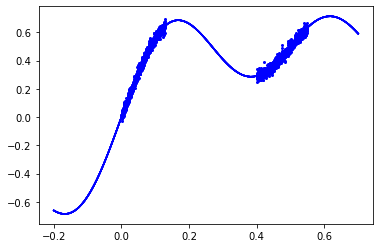

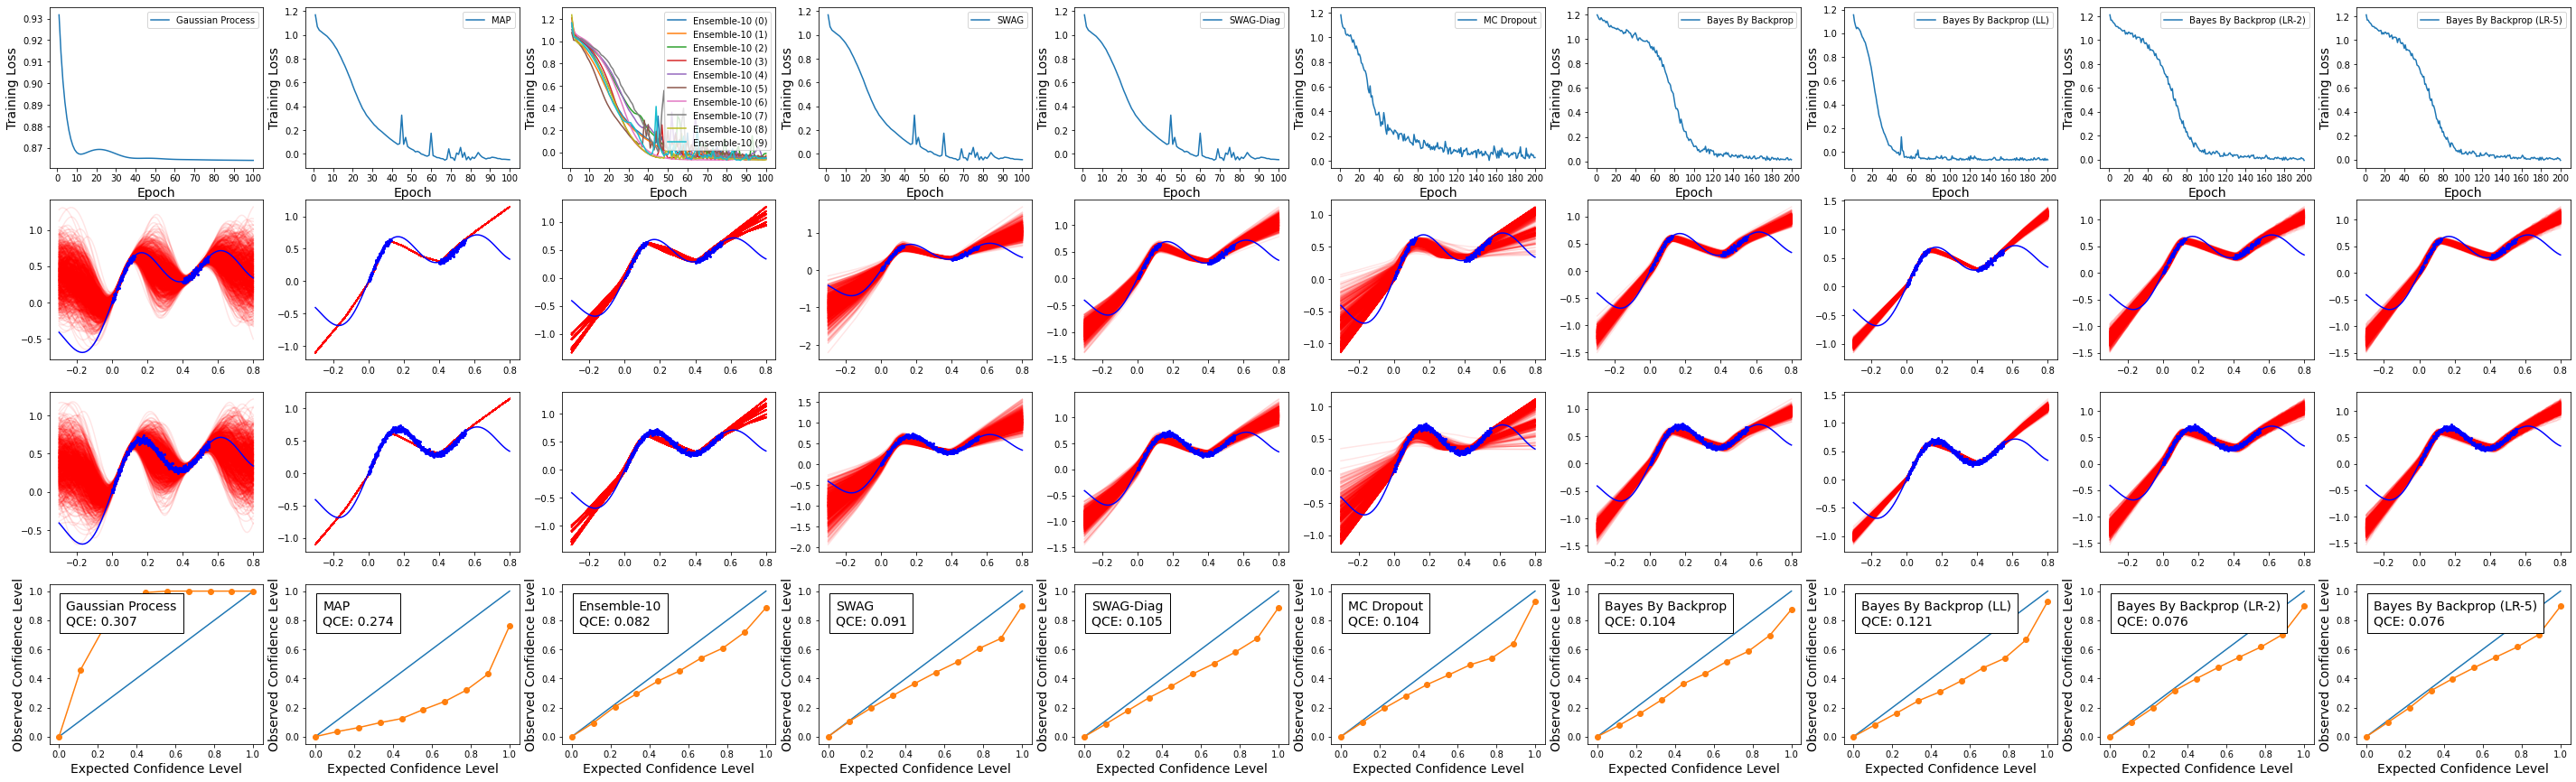

In [22]:
results = [[] for _ in range(10)]
for seed in range(10):
    torch.manual_seed(seed)
    dataset, dataloader, testset = gap_datasets(device)
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

    models = train_models(dataset, 20)
    eval_configs = [
        ("Gaussian Process", models[0], 1000),
        ("MAP", models[1], 1000),
        ("Ensemble-10", models[2], 1000),
        ("SWAG", models[3], 1000),
        ("SWAG-Diag", models[4], 1000),
        ("MC Dropout", models[5], 1000),
        ("Bayes By Backprop", models[6], 1000),
        ("Bayes By Backprop (LL)", models[7], 1000),
        ("Bayes By Backprop (LR-2)", models[8], 1000),
        ("Bayes By Backprop (LR-5)", models[8], 1000)
    ]

    for i, (name, model, samples) in enumerate(eval_configs):
        results[i].append(RegressionResults(testloader, name, model.infer, samples, device, fit_gaussian=False, target_mean=dataset.y_mean, target_std = dataset.y_std))

plot_table("Gap Toy Regression", results, "results/toy/regression_gap.txt")

fig, _ = plot_grid(dataset, testset, -0.3, 0.8, eval_configs, device)
#fig.savefig("results/toy/regression_gap.png")

# store_results(dataset, testset, -0.3, 0.8, [
#     ("gp", models[0], 1000),
#     ("map", models[1], 1000),
#     ("ensemble", models[2], 1000),
#     ("swag", models[3], 1000),
#     ("swag_diag", models[4], 1000),
#     ("mc_dropout", models[5], 1000),
#     ("bbb", models[6], 1000),
#     ("bbb_ll", models[7], 1000)
# ], device)